# Task 3: Correlation between News and Stock Movement
## 1. Import Libraries
To start, we'll load the required Python libraries for handling data, performing sentiment analysis, and calculating correlations

## Import Necessary Libraries
Here we import the essential libraries required for:
- Data manipulation (`pandas`)
- Numerical operations (`numpy`)
- Visualization (`matplotlib`)
- Sentiment analysis (`nltk`)


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os  # For file handling
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Download necessary NLTK data for sentiment analysis
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\leulg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Load and Clean Stock Data
This function loads all stock price files into a dictionary of pandas DataFrames.
- Ensures that dates are in a consistent `datetime.date` format.
- Drops unnecessary columns like `Dividends` and `Stock Splits` if they are all zeros.


In [33]:
def load_stock_data(data_folder, stock_files):
    stock_data = {}  # Dictionary to store stock DataFrames
    
    for file in stock_files:
        stock_name = file.split("_")[0]  # Extract stock name (e.g., AAPL, AMZN)
        path = os.path.join(data_folder, file)
        
        # Load CSV into DataFrame
        df = pd.read_csv(path)
        
        # Drop 'Dividends' and 'Stock Splits' if they are all zeros
        if 'Dividends' in df.columns and df['Dividends'].nunique() == 1:
            df = df.drop(columns=['Dividends'])
        if 'Stock Splits' in df.columns and df['Stock Splits'].nunique() == 1:
            df = df.drop(columns=['Stock Splits'])
        
        # Convert 'Date' column to datetime.date format
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        
        # Add cleaned DataFrame to dictionary
        stock_data[stock_name] = df
    
    return stock_data

# Define data folder and stock files
data_folder = "../data"  # Adjust to your folder path
stock_files = [
    "AAPL_historical_data.csv", "AMZN_historical_data.csv", "GOOG_historical_data.csv",
    "META_historical_data.csv", "MSFT_historical_data.csv", "NVDA_historical_data.csv",
    "TSLA_historical_data.csv"
]

# Load stock data
stock_data = load_stock_data(data_folder, stock_files)


## Load and Process News Sentiment Data
This function:
- Loads the news data containing dates and headlines.
- Performs sentiment analysis on each headline using NLTK's SentimentIntensityAnalyzer.
- Aggregates sentiment scores by date to compute the average sentiment for each day.


In [34]:
# Helper function to load news data
def load_news_data(news_file):
    # Load the CSV file
    news_df = pd.read_csv(news_file)

    # Display the first few rows of the date column to inspect the format (debugging)
    print(news_df['date'].head(10))

    # Convert the 'date' column to datetime, handling the timezone and retaining just the date
    news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce').dt.date

    # Drop rows where 'date' could not be parsed
    news_df = news_df.dropna(subset=['date'])

    # Retain relevant columns: 'date' and 'headline'
    news_df = news_df[['date', 'headline']]

    # Perform Sentiment Analysis
    news_df['sentiment_score'] = news_df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Group by date and calculate the average daily sentiment
    avg_sentiment = news_df.groupby('date')['sentiment_score'].mean().reset_index()
    avg_sentiment.rename(columns={'sentiment_score': 'avg_sentiment'}, inplace=True)

    return avg_sentiment


## Correlation Analysis
This function:
1. Merges stock data and news sentiment data on dates.
2. Computes daily stock returns using percentage changes in the `Close` prices.
3. Calculates the Pearson correlation coefficient between stock returns and sentiment scores.


In [35]:
def analyze_correlation(stock_data, news_sentiment):
    results = {}
    for stock_name, stock_df in stock_data.items():
        # Merge stock data with news sentiment on dates
        merged_df = pd.merge(
            stock_df, news_sentiment, 
            left_on='Date', right_on='date', 
            how='inner'
        )
        
        # Drop redundant 'date' column
        merged_df = merged_df.drop(columns=['date'])
        
        # Calculate daily stock returns
        merged_df['Daily_Return'] = merged_df['Close'].pct_change()
        
        # Drop NaN values (due to percentage change)
        merged_df = merged_df.dropna()
        
        # Calculate Pearson correlation between sentiment and returns
        correlation = merged_df['Daily_Return'].corr(merged_df['avg_sentiment'])
        results[stock_name] = correlation
    
    return results

### 2. Load Data and Perform Analysis
We load:
- Stock price data from multiple files (AAPL, AMZN, GOOG, META, MSFT, NVDA, TSLA)
- News data containing dates and headlines for sentiment analysis.
We then compute the correlation between **daily sentiment scores** and **daily stock returns**.


In [36]:
# Define folder paths and file names
data_folder = "../data"  # Adjust to your data folder path
news_file = os.path.join(data_folder, "raw_analyst_ratings.csv")

# List of stock files
stock_files = [
    "AAPL_historical_data.csv", "AMZN_historical_data.csv", 
    "GOOG_historical_data.csv", "META_historical_data.csv", 
    "MSFT_historical_data.csv", "NVDA_historical_data.csv", 
    "TSLA_historical_data.csv"
]

# Load stock data and news sentiment data
stock_data = load_stock_data(data_folder, stock_files)
news_sentiment = load_news_data(news_file)

# Perform correlation analysis
correlation_results = analyze_correlation(stock_data, news_sentiment)

# Display correlation results
print("\nCorrelation Between News Sentiment and Stock Returns:")
for stock, correlation in correlation_results.items():
    print(f"{stock}: {correlation:.4f}")


0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
5    2020-05-22 11:23:25-04:00
6    2020-05-22 09:36:20-04:00
7    2020-05-22 09:07:04-04:00
8    2020-05-22 08:37:59-04:00
9    2020-05-22 08:06:17-04:00
Name: date, dtype: object

Correlation Between News Sentiment and Stock Returns:
AAPL: 0.0421
AMZN: -0.0022
GOOG: 0.0240
META: -0.0101
MSFT: 0.0281
NVDA: 0.0222
TSLA: -0.0167


### 3. Visualize Correlation Results
We plot the correlation results to understand how closely the news sentiment aligns with daily stock returns for each stock.


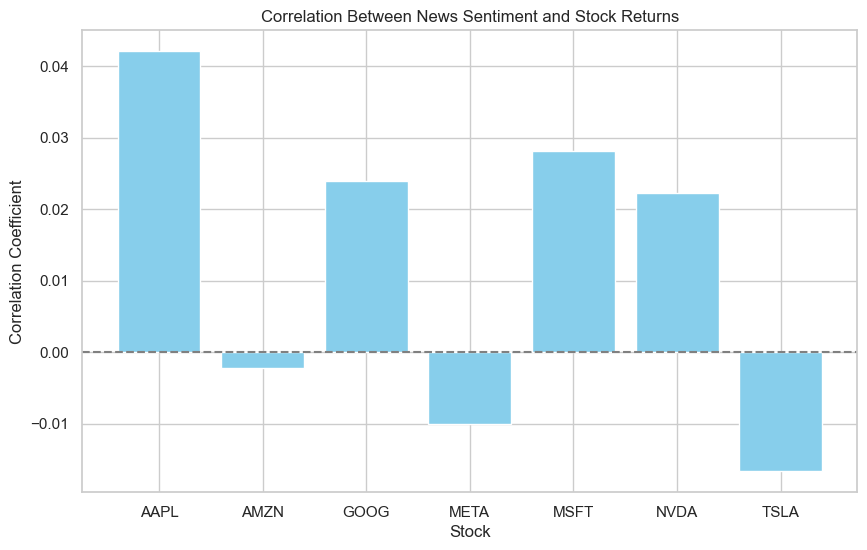

In [37]:
# Visualize correlation results
plt.figure(figsize=(10, 6))
plt.bar(correlation_results.keys(), correlation_results.values(), color='skyblue')
plt.title("Correlation Between News Sentiment and Stock Returns")
plt.xlabel("Stock")
plt.ylabel("Correlation Coefficient")
plt.axhline(0, color='grey', linestyle='--')
plt.show()
